# World of Julia

*First published: 2014-06-30*

*Updated: 2016-03-16*

*Jiahao Chen, MIT*

Have you ever wondered who contributes to Julia? This notebook explores basic facets of the Julia community.

(Note: For best results, make sure you have an ImageMagick build with OpenMP support enabled.)

First, load up a bunch of packages written by the Julia community.

In [1]:
using Compat
using Compose
using Gadfly
using GitHub
using HDF5, JLD
using Interact
using MetadataTools
using JSON
using ProgressMeter
using Requests
using Shapefile
using URIParser

Next, authenticate a GitHub access token for reading data from GitHub.

Substitute your own token by following [these instructions](https://help.github.com/articles/creating-an-access-token-for-command-line-use/).

In [60]:
auth_token="" #to access Github API
my_auth = authenticate(auth_token)

GitHub.OAuth2(171263**********************************)

Some parts of this notebook take awhile to run because of multiple HTTP requests to various websites. Here we see if data from a previous run were stored, and load it into working memory if it does.

The storage format is `JLD`, which is a `HDF5` file with a particular way to describe arbitrary Julia types.

In [3]:
try if isfile("worldofjulia.jld")
    A = JLD.load("worldofjulia.jld")
    locations = A["locations"]
    juliastargazers = A["juliastargazers"]
    juliawatchers = A["juliawatchers"]
    juliacontributors = A["juliacontributors"]
    allcontributors = A["allcontributors"]
end end

# The main Julia repository

Let's start with the main repository.

In [4]:
authors=contributors("JuliaLang/julia", auth=my_auth)[1]
println("$(length(authors)) contributors found for JuliaLang/julia")

445 contributors found for JuliaLang/julia


## An avatar montage

GitHub provides detailed information about user profiles.

One fun thing to do is to download everyone's [profile pictures](https://help.github.com/articles/how-do-i-set-up-my-profile-picture/) and turn them into a montage using [ImageMagick](http://www.imagemagick.org).

Julia provides a native `download` function, which is convenient but forks an external command such as `curl` or `wget` each time it is run. To download many small files, it is more convient to use `Requests.jl`.

`dl` below is a basic working replacement for `download`.

In [5]:
dl(url::Nullable{URI}, filename, tries = 3) = 
    if isnull(url)
        throw(ArgumentError("Cannot dl($url)"))
    else
        dl(get(url), filename, tries)
    end

dl(url, filename, tries=3) = dl(URI(url), filename, tries)

#Download data from a given URL to a file.
function dl(url::URI, filename, tries = 3)
    isfile(filename) && return #Don't overwrite existing files
    r = nothing
    for i=1:tries
        try
            r = get(url)
            
            r.status == 200 && break

            if contains(r.headers["Content-Type"], "text/html")
                display("text/html", r.data)
            end
            r.status == 302 && break #Redirection
        catch e
            warn(e)
        end
        sleep(3)
    end
    if r!=nothing && r.status == 200
        open(filename, "w") do f
            write(f, r.data)
        end
    else
        warn("Could not download $url\nStatus: $(r.status)")
    end
end

dl (generic function with 6 methods)

Next, use `dl` to download the avatars associated with an iterable collection of authors. We also use ImageMagick's `mogrify` command to automatically resize each avatar file to 64x64 pixels.

`getavatars` can take awhile, so we use `ProgressMeter.@showprogress` to show a progress bar for the main loop over the `authors`.

In [6]:
#Download everyone's avatars
function getavatars(authors; verbose::Bool=false)
    const mogrify = `/usr/local/bin/mogrify`
    
    avatarfiles = Dict()
    @showprogress for author in authors
        login = get(author["contributor"].login)
        avatarfilename = string(login, ".png")
        if !isfile(avatarfilename)
            url = author["contributor"].avatar_url
            verbose && info("Downloading avatar for $login")
            dl(url, avatarfilename)
            run(`$mogrify -resize 64x64 $avatarfilename`)
        else
            verbose && info("Avatar for $login already downloaded")
        end
        avatarfiles[login] = avatarfilename
    end
    avatarfiles
end
avatarfiles = getavatars(authors)

Dict{Any,Any} with 445 entries:
  "agoddard"        => "agoddard.png"
  "davidkh"         => "davidkh.png"
  "cameyo42"        => "cameyo42.png"
  "JeffBezanson"    => "JeffBezanson.png"
  "btracey"         => "btracey.png"
  "rmyorston"       => "rmyorston.png"
  "dancasimiro"     => "dancasimiro.png"
  "schenker"        => "schenker.png"
  "julian-gehring"  => "julian-gehring.png"
  "cicku"           => "cicku.png"
  "catawbasam"      => "catawbasam.png"
  "GunnarFarneback" => "GunnarFarneback.png"
  "autozimu"        => "autozimu.png"
  "goretkin"        => "goretkin.png"
  "doomsplayer"     => "doomsplayer.png"
  "PallHaraldsson"  => "PallHaraldsson.png"
  "garrison"        => "garrison.png"
  "randyzwitch"     => "randyzwitch.png"
  "peterdn"         => "peterdn.png"
  "doowttam"        => "doowttam.png"
  "cbecker"         => "cbecker.png"
  "patrickyevsukov" => "patrickyevsukov.png"
  "jgoldfar"        => "jgoldfar.png"
  "shashi"          => "shashi.png"
  "dcampbell24"     => 

Finally, use [ImageMagick's](http://www.imagemagick.org) `montage` to create a montage of contributors to the main `julia` repository using their GitHub avatars. Each avatar can also be sorted and annotated by the number of commits to the repository.

In [7]:
function makemontage(filename, authors, avatarfiles; layout=nothing)
    cmd = `montage`
    layout==nothing || (cmd = `$cmd -tile $(layout[1])x$(layout[2])`)
    σ = sortperm([author["contributions"] for author in authors], rev=true)
    for idx in σ
        author = authors[idx]
        login, contribs = get(author["contributor"].login), author["contributions"]
        if !haskey(avatarfiles, login)
            warn("Skipping user $login: no associated entry in avatarfiles")
            continue
        end

        avatarfile = avatarfiles[login]
        if !isfile(avatarfile)
            warn("Skipping user $login: no file $avatarfile")
            continue
        end
        cmd = `$cmd -label "$login\n($contribs)" $avatarfile`
    end
    cmd = `$cmd -geometry 64x64+16+16 -font Helvetica $filename`
end

makemontage (generic function with 1 method)

In [8]:
#Compute montage layout
aspectratio = φ #Golden ratio
ntiles=√(length(authors)/aspectratio)
ntilesx, ntilesy = ceil(Int, aspectratio*ntiles), ceil(Int, ntiles)

(27,17)

In [9]:
cmd = makemontage("montage_juliaonly.jpg", authors, avatarfiles, layout = (ntilesx, ntilesy));

In [10]:
#@time run(cmd)

<img src="montage_juliaonly.jpg"/>

# Including Julia packages

Julia has a rapidly growing list of [registered packages](http://pkg.julialang.org/) which represent the efforts of yet more developers. We can make another montage of contributors, this time including all package authors also.

Use the built-in `Pkg` module to get a list of available packages, then use `MetadataTools.get_pkg` to retrieve all the associated package metadata and retrieve the GitHub owners and repository names using `URIParser.parse_url`.

In [11]:
#Scan package metadata and get URLs for all registered packages
Packages = Any[]
@showprogress for pkg in Pkg.available()
    url = URIParser.parse_url(get_pkg(pkg).url)
    if url.host == "github.com"
        _, owner, repo = try
            split(url.path, '/')
        catch exc
            println(STDERR, "Error parsing $(url.path) from $url")
            rethrow(exc)
        end
        repo = split(repo, ".git")[1]
        push!(Packages, (owner, repo))
    else
        warn("Skipping non-GitHub repo $url")
    end
end
println("$(length(Packages)) packages found.")

Progress:  61%  ETA: 0:00:00

Progress: 100% Time: 0:00:01


Now we can query each package's GitHub repository for its corresponding list of contributors and commit counts, merging the contribution counts back into `authors` for a total count across all the repositories.

In [12]:
#Update authors with package contributors
#Collates all the contribution counts also
function addpkgcounts!(authors, Packages)
    @showprogress for (owner, repo) in Packages
        thispkg_contributors = try
            contributors(owner*"/"*repo, auth=my_auth)[1]
        catch
            warn("Skipping $owner/$repo")
            continue
        end

        isnew = true
        #Merge global statistics
        for entry in thispkg_contributors
            contributor = entry["contributor"]
            for (i, authordata) in enumerate(authors)
                if get(authordata["contributor"].login) == get(contributor.login)
                    isnew = false
                    authors[i]["contributions"] += entry["contributions"]
                    break
                end
            end
            isnew && push!(authors, entry)
        end
    end
end
    
juliacontributors = copy(authors)
addpkgcounts!(authors, Packages)

878 packages found.
Progress: 100% Time: 0:06:58


As before, grab everyone's avatars.

In [13]:
avatarfiles = getavatars(authors)

Dict{Any,Any} with 727 entries:
  "btracey"         => "btracey.png"
  "benhamner"       => "benhamner.png"
  "schenker"        => "schenker.png"
  "nstiurca"        => "nstiurca.png"
  "pearlzli"        => "pearlzli.png"
  "GunnarFarneback" => "GunnarFarneback.png"
  "njwilson23"      => "njwilson23.png"
  "garrison"        => "garrison.png"
  "randyzwitch"     => "randyzwitch.png"
  "jdrugo"          => "jdrugo.png"
  "lvnguyen"        => "lvnguyen.png"
  "jcorbin"         => "jcorbin.png"
  "yipihey"         => "yipihey.png"
  "jey"             => "jey.png"
  "davidlizeng"     => "davidlizeng.png"
  "cstjean"         => "cstjean.png"
  "goedman"         => "goedman.png"
  "charlesll"       => "charlesll.png"
  "fhs"             => "fhs.png"
  "mpf"             => "mpf.png"
  "mcprentiss"      => "mcprentiss.png"
  "jayschwa"        => "jayschwa.png"
  "domenzain"       => "domenzain.png"
  "LeoK987"         => "LeoK987.png"
  "mdavezac"        => "mdavezac.png"
  ⋮                 =

And now we can make a new montage.

In [14]:
#Compute montage layout
aspectratio = φ
ntiles=√(length(authors)/aspectratio)
ntilesx, ntilesy = ceil(Int, aspectratio*ntiles), ceil(Int, ntiles)

(35,22)

In [15]:
cmd = makemontage("montage_julia.jpg", authors, avatarfiles, layout = (ntilesx, ntilesy));

In [16]:
@time run(cmd)

LoadError: LoadError: could not spawn `montage -tile 35x22 -label 'JeffBezanson\n(7584)' JeffBezanson.png -label 'timholy\n(4428)' timholy.png -label 'StefanKarpinski\n(3684)' StefanKarpinski.png -label 'ViralBShah\n(2840)' ViralBShah.png -label 'lindahua\n(2749)' lindahua.png -label 'jakebolewski\n(2539)' jakebolewski.png -label 'dlfivefifty\n(2299)' dlfivefifty.png -label 'mlubin\n(2164)' mlubin.png -label 'SimonDanisch\n(2131)' SimonDanisch.png -label 'vtjnash\n(1979)' vtjnash.png -label 'MikeInnes\n(1878)' MikeInnes.png -label 'simonster\n(1775)' simonster.png -label 'dcjones\n(1752)' dcjones.png -label 'tkelman\n(1747)' tkelman.png -label 'Keno\n(1711)' Keno.png -label 'stevengj\n(1667)' stevengj.png -label 'IainNZ\n(1578)' IainNZ.png -label 'jiahao\n(1447)' jiahao.png -label 'johnmyleswhite\n(1373)' johnmyleswhite.png -label 'nolta\n(1278)' nolta.png -label 'rgiordan\n(1233)' rgiordan.png -label 'shashi\n(1186)' shashi.png -label 'pluskid\n(1131)' pluskid.png -label 'ChrisTimperley\n(1078)' ChrisTimperley.png -label 'weijianzhang\n(1042)' weijianzhang.png -label 'dmbates\n(989)' dmbates.png -label 'andreasnoack\n(984)' andreasnoack.png -label 'joshday\n(951)' joshday.png -label 'carlobaldassi\n(921)' carlobaldassi.png -label 'andrewcooke\n(917)' andrewcooke.png -label 'joehuchette\n(882)' joehuchette.png -label 'brian-j-smith\n(878)' brian-j-smith.png -label 'codles\n(840)' codles.png -label 'staticfloat\n(839)' staticfloat.png -label 'yuyichao\n(835)' yuyichao.png -label 'quinnj\n(815)' quinnj.png -label 'kmsquire\n(775)' kmsquire.png -label 'tbreloff\n(751)' tbreloff.png -label 'wbhart\n(706)' wbhart.png -label 'tanmaykm\n(697)' tanmaykm.png -label 'ihnorton\n(694)' ihnorton.png -label 'r9y9\n(681)' r9y9.png -label 'jverzani\n(668)' jverzani.png -label 'davidavdav\n(653)' davidavdav.png -label 'ehsantn\n(642)' ehsantn.png -label 'sbromberger\n(640)' sbromberger.png -label 'MichaelHatherly\n(638)' MichaelHatherly.png -label 'amitmurthy\n(616)' amitmurthy.png -label 'tonyhffong\n(569)' tonyhffong.png -label 'scidom\n(561)' scidom.png -label 'MikaelSlevinsky\n(537)' MikaelSlevinsky.png -label 'sjkelly\n(528)' sjkelly.png -label 'simonbyrne\n(522)' simonbyrne.png -label 'WestleyArgentum\n(519)' WestleyArgentum.png -label 'madeleineudell\n(514)' madeleineudell.png -label 'aviks\n(492)' aviks.png -label 'Luthaf\n(492)' Luthaf.png -label 'samoconnor\n(469)' samoconnor.png -label 'dpsanders\n(456)' dpsanders.png -label 'montyvesselinov\n(450)' montyvesselinov.png -label 'jzuhone\n(446)' jzuhone.png -label 'diegozea\n(445)' diegozea.png -label 'robertfeldt\n(443)' robertfeldt.png -label 'bicycle1885\n(442)' bicycle1885.png -label 'spencerlyon2\n(440)' spencerlyon2.png -label 'jeff-regier\n(435)' jeff-regier.png -label 'trthatcher\n(434)' trthatcher.png -label 'goedman\n(422)' goedman.png -label 'kshyatt\n(420)' kshyatt.png -label 'jrevels\n(413)' jrevels.png -label 'powerdistribution\n(409)' powerdistribution.png -label 'DrTodd13\n(400)' DrTodd13.png -label 'KristofferC\n(395)' KristofferC.png -label 'cgroll\n(392)' cgroll.png -label 'malmaud\n(387)' malmaud.png -label 'zenna\n(381)' zenna.png -label 'tshort\n(377)' tshort.png -label 'randyzwitch\n(376)' randyzwitch.png -label 'benhamner\n(374)' benhamner.png -label 'garborg\n(363)' garborg.png -label 'eschnett\n(359)' eschnett.png -label 'tlycken\n(359)' tlycken.png -label 'macrintr\n(359)' macrintr.png -label 'toivoh\n(356)' toivoh.png -label 'jumutc\n(347)' jumutc.png -label 'tpoisot\n(325)' tpoisot.png -label 'thofma\n(321)' thofma.png -label 'mbauman\n(319)' mbauman.png -label 'tinybike\n(317)' tinybike.png -label 'Evizero\n(317)' Evizero.png -label 'ninegua\n(313)' ninegua.png -label 'fredo-dedup\n(312)' fredo-dedup.png -label 'samuel-massinon-invenia\n(307)' samuel-massinon-invenia.png -label 'alyst\n(305)' alyst.png -label 'kbarbary\n(303)' kbarbary.png -label 'mweastwood\n(298)' mweastwood.png -label 'omus\n(291)' omus.png -label 'jaak-s\n(285)' jaak-s.png -label 'astrieanna\n(284)' astrieanna.png -label 'lbenet\n(284)' lbenet.png -label 'emoszkowski\n(284)' emoszkowski.png -label 'julian-gehring\n(281)' julian-gehring.png -label 'autozimu\n(280)' autozimu.png -label 'karanveerm\n(275)' karanveerm.png -label 'pao\n(267)' pao.png -label 'mschauer\n(267)' mschauer.png -label 'imanuelcostigan\n(257)' imanuelcostigan.png -label 'dodamih\n(249)' dodamih.png -label 'micahjsmith\n(248)' micahjsmith.png -label 'rennis250\n(246)' rennis250.png -label 'dfdx\n(244)' dfdx.png -label 'zachallaun\n(242)' zachallaun.png -label 'juliohm\n(242)' juliohm.png -label 'zyedidia\n(241)' zyedidia.png -label 'wildart\n(239)' wildart.png -label 'matthieugomez\n(233)' matthieugomez.png -label 'sfchen\n(227)' sfchen.png -label 'nalimilan\n(226)' nalimilan.png -label 'ivarne\n(223)' ivarne.png -label 'nassarhuda\n(223)' nassarhuda.png -label 'JayKickliter\n(217)' JayKickliter.png -label 'fairbrot\n(216)' fairbrot.png -label 'ovainola\n(213)' ovainola.png -label 'lkuper\n(208)' lkuper.png -label 'BenLauwens\n(202)' BenLauwens.png -label 'omalled\n(201)' omalled.png -label 'boyers\n(200)' boyers.png -label 'gp0\n(200)' gp0.png -label 'ahojukka5\n(200)' ahojukka5.png -label 'pearlzli\n(199)' pearlzli.png -label 'ssfrr\n(198)' ssfrr.png -label 'Michael-Klassen\n(194)' Michael-Klassen.png -label 'HarlanH\n(191)' HarlanH.png -label 'tawheeler\n(181)' tawheeler.png -label 'davidagold\n(178)' davidagold.png -label 'richardreeve\n(178)' richardreeve.png -label 'jayschwa\n(176)' jayschwa.png -label 'meggart\n(173)' meggart.png -label 'mykelk\n(173)' mykelk.png -label 'nkottary\n(172)' nkottary.png -label 'svs14\n(172)' svs14.png -label 'phrb\n(172)' phrb.png -label 'gummif\n(171)' gummif.png -label 'ulfworsoe\n(171)' ulfworsoe.png -label 'jpata\n(162)' jpata.png -label 'blakejohnson\n(161)' blakejohnson.png -label 'zhmz90\n(160)' zhmz90.png -label 'andrioni\n(159)' andrioni.png -label 'yeesian\n(157)' yeesian.png -label 'garrison\n(151)' garrison.png -label 'jheinen\n(151)' jheinen.png -label 'davidlizeng\n(150)' davidlizeng.png -label 'vchuravy\n(143)' vchuravy.png -label 'jhlq\n(143)' jhlq.png -label 'jdtuck\n(142)' jdtuck.png -label 'tedsteiner\n(140)' tedsteiner.png -label 'rsrock\n(139)' rsrock.png -label 'yurivish\n(139)' yurivish.png -label 'ScottPJones\n(135)' ScottPJones.png -label 'emmt\n(135)' emmt.png -label 'felipenoris\n(134)' felipenoris.png -label 'mpastell\n(133)' mpastell.png -label 'chkwon\n(133)' chkwon.png -label 'dancasimiro\n(132)' dancasimiro.png -label 'rollingthunder\n(130)' rollingthunder.png -label 'TeroFrondelius\n(129)' TeroFrondelius.png -label 'Jutho\n(128)' Jutho.png -label 'tknopp\n(128)' tknopp.png -label 'panlanfeng\n(128)' panlanfeng.png -label 'andferrari\n(127)' andferrari.png -label 'davidanthoff\n(126)' davidanthoff.png -label 'samuelcolvin\n(126)' samuelcolvin.png -label 'hayd\n(124)' hayd.png -label 'dhoegh\n(124)' dhoegh.png -label 'JackDunnNZ\n(124)' JackDunnNZ.png -label 'lgautier\n(124)' lgautier.png -label 'phobon\n(122)' phobon.png -label 'gragusa\n(122)' gragusa.png -label 'helgee\n(118)' helgee.png -label 'jbn\n(116)' jbn.png -label 'reworkhow\n(114)' reworkhow.png -label 'hng\n(113)' hng.png -label 'keithseahus\n(113)' keithseahus.png -label 'randy3k\n(112)' randy3k.png -label 'dirkschumacher\n(111)' dirkschumacher.png -label 'jipolanco\n(110)' jipolanco.png -label 'pzion\n(109)' pzion.png -label 'null-a\n(109)' null-a.png -label 'TotalVerb\n(108)' TotalVerb.png -label 'Rory-Finnegan\n(108)' Rory-Finnegan.png -label 'chezou\n(105)' chezou.png -label 'aaronstanton\n(105)' aaronstanton.png -label 'burrowsa\n(104)' burrowsa.png -label 'rohitvarkey\n(104)' rohitvarkey.png -label 'jlapeyre\n(103)' jlapeyre.png -label 'fhs\n(103)' fhs.png -label 'cstjean\n(103)' cstjean.png -label 'skariel\n(102)' skariel.png -label 'jgoldfar\n(102)' jgoldfar.png -label 'porterjamesj\n(101)' porterjamesj.png -label 'denizyuret\n(99)' denizyuret.png -label 'darwindarak\n(98)' darwindarak.png -label 'LaurenceA\n(97)' LaurenceA.png -label 'glesica\n(97)' glesica.png -label 'jpfairbanks\n(95)' jpfairbanks.png -label 'Sean1708\n(93)' Sean1708.png -label 'prcastro\n(92)' prcastro.png -label 'oheil\n(92)' oheil.png -label 'ReidAtcheson\n(92)' ReidAtcheson.png -label 'codeneomatrix\n(91)' codeneomatrix.png -label 'mfalt\n(90)' mfalt.png -label 'catawbasam\n(89)' catawbasam.png -label 'rened\n(89)' rened.png -label 'carnaval\n(88)' carnaval.png -label 'daviddelaat\n(87)' daviddelaat.png -label 'damiendr\n(87)' damiendr.png -label 'ahwillia\n(87)' ahwillia.png -label 'quxiaofeng\n(87)' quxiaofeng.png -label 'twadleigh\n(86)' twadleigh.png -label 'ajt60gaibb\n(85)' ajt60gaibb.png -label 'iamed2\n(84)' iamed2.png -label 'davidssmith\n(82)' davidssmith.png -label 'phaverty\n(82)' phaverty.png -label 'abeschneider\n(82)' abeschneider.png -label 'rtrochet\n(82)' rtrochet.png -label 'rfourquet\n(81)' rfourquet.png -label 'bjarthur\n(81)' bjarthur.png -label 'blegat\n(81)' blegat.png -label 'GeorgeXing\n(79)' GeorgeXing.png -label 'ArchRobison\n(79)' ArchRobison.png -label 'bardwell\n(79)' bardwell.png -label 'ivanslapnicar\n(78)' ivanslapnicar.png -label 'danielmendel\n(76)' danielmendel.png -label 'christianpeel\n(75)' christianpeel.png -label 'eraviart\n(75)' eraviart.png -label 'JoelHobson\n(73)' JoelHobson.png -label 'GordStephen\n(71)' GordStephen.png -label 'swadey\n(70)' swadey.png -label 'nwh\n(70)' nwh.png -label 'snotskie\n(70)' snotskie.png -label 'latticetower\n(69)' latticetower.png -label 'DANA-Laboratory\n(68)' DANA-Laboratory.png -label 'bfredl\n(68)' bfredl.png -label 'leonardt\n(68)' leonardt.png -label 'dahlend\n(67)' dahlend.png -label 'robertdj\n(67)' robertdj.png -label 'mauro3\n(66)' mauro3.png -label 'danielsuo\n(66)' danielsuo.png -label 'waldyrious\n(65)' waldyrious.png -label 'shangmu\n(65)' shangmu.png -label 'danspielman\n(65)' danspielman.png -label 'Tao-Hu\n(65)' Tao-Hu.png -label 'pygy\n(64)' pygy.png -label 'bdeonovic\n(64)' bdeonovic.png -label 'lcw\n(63)' lcw.png -label 'simulkade\n(63)' simulkade.png -label 'lruthotto\n(61)' lruthotto.png -label 'magistere\n(60)' magistere.png -label 'rawls238\n(60)' rawls238.png -label 'lucasb-eyer\n(59)' lucasb-eyer.png -label 'dls\n(59)' dls.png -label 'IshitaTakeshi\n(59)' IshitaTakeshi.png -label 'scheinerman\n(57)' scheinerman.png -label 'jwmerrill\n(57)' jwmerrill.png -label 'lendle\n(56)' lendle.png -label 'sam81\n(56)' sam81.png -label 'greenflash1357\n(55)' greenflash1357.png -label 'charlesll\n(54)' charlesll.png -label 'odow\n(53)' odow.png -label 'innerlee\n(53)' innerlee.png -label 'acroy\n(52)' acroy.png -label 'Wilfred\n(51)' Wilfred.png -label 'wavexx\n(51)' wavexx.png -label 'rdeits\n(51)' rdeits.png -label 'pjabardo\n(51)' pjabardo.png -label 'yarlett\n(51)' yarlett.png -label 'kersulis\n(50)' kersulis.png -label 'dpo\n(50)' dpo.png -label 'sawcordwell\n(49)' sawcordwell.png -label 'sebastien-villemot\n(48)' sebastien-villemot.png -label 'bensadeghi\n(47)' bensadeghi.png -label 'TheBB\n(47)' TheBB.png -label 'Ward9250\n(47)' Ward9250.png -label 'maleadt\n(46)' maleadt.png -label 'cc7768\n(46)' cc7768.png -label 'giordano\n(46)' giordano.png -label 'rjagerman\n(46)' rjagerman.png -label 'antinucleon\n(46)' antinucleon.png -label 'cormullion\n(44)' cormullion.png -label 'kzahedi\n(44)' kzahedi.png -label 'sbos\n(43)' sbos.png -label 'natj\n(43)' natj.png -label 'Smaug123\n(43)' Smaug123.png -label 'Azzaare\n(43)' Azzaare.png -label 'zingales\n(42)' zingales.png -label 'stefan-k\n(42)' stefan-k.png -label 'vonDonnerstein\n(42)' vonDonnerstein.png -label 'yunjhongwu\n(42)' yunjhongwu.png -label 'sunetos\n(42)' sunetos.png -label 'jhasse\n(41)' jhasse.png -label 'milktrader\n(41)' milktrader.png -label 'KDr2\n(40)' KDr2.png -label 'ggggggggg\n(40)' ggggggggg.png -label 'mbaz\n(40)' mbaz.png -label 'ayakimovich\n(39)' ayakimovich.png -label 'pozorvlak\n(37)' pozorvlak.png -label 'compressed\n(36)' compressed.png -label 'spurll\n(36)' spurll.png -label 'BigCrunsh\n(36)' BigCrunsh.png -label 'mrxiaohe\n(36)' mrxiaohe.png -label 'Aerlinger\n(34)' Aerlinger.png -label 'benmoran\n(34)' benmoran.png -label 'bass3m\n(34)' bass3m.png -label 'pkofod\n(33)' pkofod.png -label 'anthonyclays\n(33)' anthonyclays.png -label 'rawrgrr\n(32)' rawrgrr.png -label 'ekobir\n(32)' ekobir.png -label 'nirinA\n(32)' nirinA.png -label 'JockLawrie\n(32)' JockLawrie.png -label 'danluu\n(31)' danluu.png -label 'ninjin\n(31)' ninjin.png -label 'mkriele\n(31)' mkriele.png -label 'cyrusmaher\n(31)' cyrusmaher.png -label 'jonasrauber\n(30)' jonasrauber.png -label 'c42f\n(29)' c42f.png -label 'jennyhong\n(29)' jennyhong.png -label 'billmclean\n(29)' billmclean.png -label 'RJDennis\n(29)' RJDennis.png -label 'tqchen\n(29)' tqchen.png -label 'jcorbin\n(28)' jcorbin.png -label 'waTeim\n(28)' waTeim.png -label 'dirk\n(28)' dirk.png -label 'pwl\n(28)' pwl.png -label 'DeVerMyst\n(28)' DeVerMyst.png -label '4gh\n(28)' 4gh.png -label 'slyrz\n(27)' slyrz.png -label 'ranjanan\n(27)' ranjanan.png -label 'serbanstan\n(27)' serbanstan.png -label 'BRONSOLO\n(27)' BRONSOLO.png -label 'crayxt\n(26)' crayxt.png -label 'crbinz\n(26)' crbinz.png -label 'pfitzseb\n(25)' pfitzseb.png -label 'Betawolf\n(25)' Betawolf.png -label 'PhillP\n(25)' PhillP.png -label 'marcusps\n(24)' marcusps.png -label 'tmlbl\n(24)' tmlbl.png -label 'timothyrenner\n(24)' timothyrenner.png -label 'jcrist\n(24)' jcrist.png -label 'KayleaHaynes\n(23)' KayleaHaynes.png -label 'njwilson23\n(23)' njwilson23.png -label 'wookay\n(23)' wookay.png -label 'Pbellive\n(23)' Pbellive.png -label 'pabloferz\n(22)' pabloferz.png -label 'nlhepler\n(22)' nlhepler.png -label 'aaalexandrov\n(22)' aaalexandrov.png -label 'joidegn\n(22)' joidegn.png -label 'DrKrar\n(22)' DrKrar.png -label 'klpn\n(22)' klpn.png -label 'wesbarnett\n(22)' wesbarnett.png -label 'tchajed\n(22)' tchajed.png -label 'Ismael-VC\n(21)' Ismael-VC.png -label 'gajomi\n(21)' gajomi.png -label 'SamChill\n(21)' SamChill.png -label 'amellnik\n(21)' amellnik.png -label 'arypurnomoz\n(21)' arypurnomoz.png -label 'mguzmann\n(21)' mguzmann.png -label 'nstiurca\n(21)' nstiurca.png -label 'rsofaer\n(20)' rsofaer.png -label 'goretkin\n(20)' goretkin.png -label 'fundamental\n(20)' fundamental.png -label 'oschulz\n(20)' oschulz.png -label 'gerhardtulzer\n(20)' gerhardtulzer.png -label 'jacksonthea\n(20)' jacksonthea.png -label 'ararslan\n(20)' ararslan.png -label 'kpamnany\n(19)' kpamnany.png -label 'GlenHertz\n(19)' GlenHertz.png -label 'cbecker\n(19)' cbecker.png -label 'AndyGreenwell\n(19)' AndyGreenwell.png -label 'schmrlng\n(19)' schmrlng.png -label 'baggepinnen\n(19)' baggepinnen.png -label 'droidicus\n(19)' droidicus.png -label 'oxinabox\n(19)' oxinabox.png -label 'nanosec\n(18)' nanosec.png -label 'GunnarFarneback\n(18)' GunnarFarneback.png -label 'rickhg12hs\n(18)' rickhg12hs.png -label 'wsliang\n(18)' wsliang.png -label 'marcusdavidwebb\n(18)' marcusdavidwebb.png -label 'LMescheder\n(18)' LMescheder.png -label 'stokasto\n(18)' stokasto.png -label 'invalid-email-address\n(18)' invalid-email-address.png -label 'mfasi\n(17)' mfasi.png -label 'StephenVavasis\n(17)' StephenVavasis.png -label 'chuckha\n(17)' chuckha.png -label 'scheidan\n(17)' scheidan.png -label 'swt30\n(17)' swt30.png -label 'joshuamiller\n(17)' joshuamiller.png -label 'caryan\n(17)' caryan.png -label 'baruchel\n(17)' baruchel.png -label 'GDPlumb\n(17)' GDPlumb.png -label 'adambom\n(16)' adambom.png -label 'jtravs\n(16)' jtravs.png -label 'mpf\n(16)' mpf.png -label 'ntessore\n(16)' ntessore.png -label 's2maki\n(16)' s2maki.png -label 'slundberg\n(16)' slundberg.png -label 'gusl\n(16)' gusl.png -label 'indiedotkim\n(16)' indiedotkim.png -label 'jkaye2012\n(16)' jkaye2012.png -label 'maxvoxel8\n(16)' maxvoxel8.png -label 'VHaravy\n(15)' VHaravy.png -label 'Sacha0\n(15)' Sacha0.png -label 'PallHaraldsson\n(15)' PallHaraldsson.png -label 'elehcim\n(15)' elehcim.png -label 'petercolberg\n(15)' petercolberg.png -label 'jdrugo\n(15)' jdrugo.png -label 'visr\n(15)' visr.png -label 'AndreyKolev\n(15)' AndreyKolev.png -label 'rickedanielson\n(15)' rickedanielson.png -label 'mdavezac\n(15)' mdavezac.png -label 'fabianlischka\n(14)' fabianlischka.png -label 'Elzair\n(14)' Elzair.png -label 'bramtayl\n(14)' bramtayl.png -label 'evanfields\n(14)' evanfields.png -label 'stemann\n(14)' stemann.png -label 'DanielArndt\n(13)' DanielArndt.png -label 'cdsousa\n(13)' cdsousa.png -label 'nowozin\n(13)' nowozin.png -label 'tcfuji\n(13)' tcfuji.png -label 'reallyasi9\n(13)' reallyasi9.png -label 'fcard\n(12)' fcard.png -label 'calder\n(12)' calder.png -label 'binarybana\n(12)' binarybana.png -label 'mdpradeep\n(12)' mdpradeep.png -label 'dgleich\n(12)' dgleich.png -label 'afternone\n(12)' afternone.png -label 'dcampbell24\n(11)' dcampbell24.png -label 'drepper\n(11)' drepper.png -label 'brendano\n(11)' brendano.png -label 'samuelpowell\n(11)' samuelpowell.png -label 'boydgreenfield\n(11)' boydgreenfield.png -label 'mweiden\n(11)' mweiden.png -label 'ahalwright\n(11)' ahalwright.png -label 'Daagr\n(11)' Daagr.png -label 'dslate\n(10)' dslate.png -label 'xhochy\n(10)' xhochy.png -label 'Cody-G\n(10)' Cody-G.png -label 'sbebo\n(10)' sbebo.png -label 'micklat\n(10)' micklat.png -label 'mlewe\n(10)' mlewe.png -label 'Lanzafame\n(10)' Lanzafame.png -label 'luchr\n(10)' luchr.png -label 'jrising\n(10)' jrising.png -label 'christophfeinauer\n(10)' christophfeinauer.png -label 'keesvp\n(10)' keesvp.png -label 'mcprentiss\n(9)' mcprentiss.png -label 'martinholters\n(9)' martinholters.png -label 'yomichi\n(9)' yomichi.png -label 'mzaffalon\n(9)' mzaffalon.png -label 'lostanlen\n(9)' lostanlen.png -label 'Dawny33\n(9)' Dawny33.png -label 'bcj\n(9)' bcj.png -label 'srp\n(9)' srp.png -label 'dioptre\n(9)' dioptre.png -label 'PaulBellette\n(9)' PaulBellette.png -label 'Lightjohn\n(9)' Lightjohn.png -label 'nutsiepully\n(8)' nutsiepully.png -label 'peerst\n(8)' peerst.png -label 'simonp0420\n(8)' simonp0420.png -label 'dronir\n(8)' dronir.png -label 'cbenz\n(8)' cbenz.png -label 'r2dbg\n(8)' r2dbg.png -label 'BenConnault\n(8)' BenConnault.png -label 'acrosby\n(8)' acrosby.png -label 'shixiao\n(8)' shixiao.png -label 'jerryzhenleicai\n(8)' jerryzhenleicai.png -label 'mdcfrancis\n(8)' mdcfrancis.png -label 'eleuven\n(7)' eleuven.png -label 'LachlanGunn\n(7)' LachlanGunn.png -label 'justbur\n(7)' justbur.png -label 'cmundi\n(7)' cmundi.png -label 'dfannius\n(7)' dfannius.png -label 'tautologico\n(7)' tautologico.png -label 'jabl\n(7)' jabl.png -label 'dreiss-isb\n(7)' dreiss-isb.png -label 'axsk\n(7)' axsk.png -label 'sachdevasushant\n(7)' sachdevasushant.png -label 'andyreagan\n(7)' andyreagan.png -label 'gganssle\n(7)' gganssle.png -label 'maximsch2\n(7)' maximsch2.png -label 'lstagner\n(6)' lstagner.png -label 'aiorla\n(6)' aiorla.png -label 'artkuo\n(6)' artkuo.png -label 'kofron\n(6)' kofron.png -label 'ikirill\n(6)' ikirill.png -label 'sbcd90\n(6)' sbcd90.png -label 'LeoK987\n(6)' LeoK987.png -label 'MurrayT\n(6)' MurrayT.png -label 'fdabl\n(6)' fdabl.png -label 'mikebryniarski\n(5)' mikebryniarski.png -label 'i2000s\n(5)' i2000s.png -label 'mariushoch\n(5)' mariushoch.png -label 'zgimbutas\n(5)' zgimbutas.png -label 'ypeels\n(5)' ypeels.png -label 'chiraganand\n(5)' chiraganand.png -label 'drrobots\n(5)' drrobots.png -label 'samuela\n(5)' samuela.png -label 'hammer\n(5)' hammer.png -label 'daanhb\n(5)' daanhb.png -label 'grayclhn\n(5)' grayclhn.png -label 'wkearn\n(5)' wkearn.png -label 'mbeltagy\n(5)' mbeltagy.png -label 'ajtulloch\n(5)' ajtulloch.png -label 'ivirshup\n(5)' ivirshup.png -label 'alanedelman\n(5)' alanedelman.png -label 'joeykrug\n(5)' joeykrug.png -label 'ermueller2000\n(5)' ermueller2000.png -label 'hongborong\n(5)' hongborong.png -label 'huwenshuo\n(5)' huwenshuo.png -label 'jerry-cai-chanjet\n(5)' jerry-cai-chanjet.png -label 'iizukak\n(5)' iizukak.png -label 'bisraelsen\n(5)' bisraelsen.png -label 'mhvannier\n(5)' mhvannier.png -label 'peterkovesi\n(5)' peterkovesi.png -label 'dreammaker\n(5)' dreammaker.png -label 'sarvjeetsinghghotra\n(4)' sarvjeetsinghghotra.png -label 'Oddan\n(4)' Oddan.png -label 'certik\n(4)' certik.png -label 'yledu\n(4)' yledu.png -label 'zygmuntszpak\n(4)' zygmuntszpak.png -label 'binnisb\n(4)' binnisb.png -label 'btracey\n(4)' btracey.png -label 'avibryant\n(4)' avibryant.png -label 'MichaeLeroy\n(4)' MichaeLeroy.png -label 'RichMorin\n(4)' RichMorin.png -label 'scw\n(4)' scw.png -label 'armgong\n(4)' armgong.png -label 'adrianlzt\n(4)' adrianlzt.png -label 'NPalopoli\n(4)' NPalopoli.png -label 'skumagai\n(4)' skumagai.png -label 'yipihey\n(4)' yipihey.png -label 'jiyinyiyong\n(4)' jiyinyiyong.png -label 'leakyMirror\n(4)' leakyMirror.png -label 'dchudz\n(4)' dchudz.png -label 'EricForgy\n(4)' EricForgy.png -label 'jasonmorton\n(4)' jasonmorton.png -label 'ginggs\n(3)' ginggs.png -label 'hessammehr\n(3)' hessammehr.png -label 'jey\n(3)' jey.png -label 'gajjanag\n(3)' gajjanag.png -label 'JonasRauch\n(3)' JonasRauch.png -label 'kevinbache\n(3)' kevinbache.png -label 'markun\n(3)' markun.png -label 'cqql\n(3)' cqql.png -label 'gitfoxi\n(3)' gitfoxi.png -label 'mmaxs\n(3)' mmaxs.png -label 'muratg\n(3)' muratg.png -label 'remusao\n(3)' remusao.png -label 'morris25\n(3)' morris25.png -label 'testurser\n(3)' testurser.png -label 'cicku\n(3)' cicku.png -label 'barche\n(3)' barche.png -label 'stevenhao\n(3)' stevenhao.png -label 'tpapp\n(3)' tpapp.png -label 'qbit\n(3)' qbit.png -label 'xanderdunn\n(3)' xanderdunn.png -label 'bnels\n(3)' bnels.png -label 'gasagna\n(3)' gasagna.png -label 'doomsplayer\n(3)' doomsplayer.png -label 'sje30\n(3)' sje30.png -label 'cfbaptista\n(3)' cfbaptista.png -label 'macd\n(3)' macd.png -label 'EQt\n(3)' EQt.png -label 'yebai\n(3)' yebai.png -label 'tlnagy\n(3)' tlnagy.png -label 'simon1103\n(3)' simon1103.png -label 'DanielHoffmann32\n(3)' DanielHoffmann32.png -label 'georgelesica-wf\n(3)' georgelesica-wf.png -label 'apeyser\n(2)' apeyser.png -label 'grinsted\n(2)' grinsted.png -label 'fjarri\n(2)' fjarri.png -label 'bkalpert\n(2)' bkalpert.png -label 'notthetup\n(2)' notthetup.png -label 'exaos\n(2)' exaos.png -label 'fpepin\n(2)' fpepin.png -label 'nzmsv\n(2)' nzmsv.png -label 'HomerReid\n(2)' HomerReid.png -label 'gloine\n(2)' gloine.png -label 'JeffreySarnoff\n(2)' JeffreySarnoff.png -label 'joachimdahl\n(2)' joachimdahl.png -label 'kk49\n(2)' kk49.png -label 'larsmans\n(2)' larsmans.png -label 'lvnguyen\n(2)' lvnguyen.png -label 'lvirgili\n(2)' lvirgili.png -label 'lbenitesanchez\n(2)' lbenitesanchez.png -label 'abhijithanilkumar\n(2)' abhijithanilkumar.png -label 'lorrden\n(2)' lorrden.png -label 'krislock\n(2)' krislock.png -label 'patrickyevsukov\n(2)' patrickyevsukov.png -label 'JosephLenton\n(2)' JosephLenton.png -label 'thepulkitagarwal\n(2)' thepulkitagarwal.png -label 'RhysU\n(2)' RhysU.png -label 'ronisbr\n(2)' ronisbr.png -label 'odysseus9672\n(2)' odysseus9672.png -label 'few\n(2)' few.png -label 'stepelu\n(2)' stepelu.png -label 'stev47\n(2)' stev47.png -label 'cameyo42\n(2)' cameyo42.png -label 'cpk26\n(2)' cpk26.png -label 'lifeissweetgood\n(2)' lifeissweetgood.png -label 'matrixmorpheus\n(2)' matrixmorpheus.png -label 'polarke\n(2)' polarke.png -label 'yui-knk\n(2)' yui-knk.png -label 'heptal\n(2)' heptal.png -label 'levskaya\n(2)' levskaya.png -label 'gideonite\n(2)' gideonite.png -label 'domenzain\n(2)' domenzain.png -label 'palango\n(2)' palango.png -label 'c-s\n(2)' c-s.png -label 'tartavull\n(2)' tartavull.png -label 'hsseung\n(2)' hsseung.png -label 'vandriasyan\n(2)' vandriasyan.png -label 'mjs2600\n(2)' mjs2600.png -label 'maartenheremans\n(2)' maartenheremans.png -label 'WneleiGao\n(2)' WneleiGao.png -label 'apleonhardt\n(1)' apleonhardt.png -label 'atlytle\n(1)' atlytle.png -label 'agoddard\n(1)' agoddard.png -label 'aytekinar\n(1)' aytekinar.png -label 'arlolra\n(1)' arlolra.png -label 'artnez\n(1)' artnez.png -label 'aplund\n(1)' aplund.png -label 'bartolsthoorn\n(1)' bartolsthoorn.png -label 'bsilbaugh\n(1)' bsilbaugh.png -label 'benyang\n(1)' benyang.png -label 'BenoitKnecht\n(1)' BenoitKnecht.png -label 'BobPortmann\n(1)' BobPortmann.png -label 'bkamins\n(1)' bkamins.png -label 'contra\n(1)' contra.png -label 'dcarrera\n(1)' dcarrera.png -label 'davidkh\n(1)' davidkh.png -label 'unsignedzero\n(1)' unsignedzero.png -label 'parpwhick\n(1)' parpwhick.png -label 'rdmitry\n(1)' rdmitry.png -label 'ohspite\n(1)' ohspite.png -label 'dphildebrandt\n(1)' dphildebrandt.png -label 'edsfocci\n(1)' edsfocci.png -label 'lightcatcher\n(1)' lightcatcher.png -label 'felipecruz\n(1)' felipecruz.png -label 'EconometricsBySimulation\n(1)' EconometricsBySimulation.png -label 'oggy\n(1)' oggy.png -label 'gvnn3\n(1)' gvnn3.png -label 'gdevanla\n(1)' gdevanla.png -label 'harikb\n(1)' harikb.png -label 'iblis17\n(1)' iblis17.png -label 'ivanmantova\n(1)' ivanmantova.png -label 'raggi\n(1)' raggi.png -label 'drjdn\n(1)' drjdn.png -label 'jimberlage\n(1)' jimberlage.png -label 'radford\n(1)' radford.png -label 'johnmcdonnell\n(1)' johnmcdonnell.png -label 'jjh42\n(1)' jjh42.png -label 'josefsachsconning\n(1)' josefsachsconning.png -label 'julienr\n(1)' julienr.png -label 'jtriley\n(1)' jtriley.png -label 'miau\n(1)' miau.png -label 'kyonifer\n(1)' kyonifer.png -label 'mlhetland\n(1)' mlhetland.png -label 'mathpup\n(1)' mathpup.png -label 'markdewing\n(1)' markdewing.png -label 'mbuettner\n(1)' mbuettner.png -label 'mason-bially\n(1)' mason-bially.png -label 'doowttam\n(1)' doowttam.png -label 'meetmauro\n(1)' meetmauro.png -label 'ajdecon\n(1)' ajdecon.png -label 'zaeleus\n(1)' zaeleus.png -label 'mpeteuil\n(1)' mpeteuil.png -label 'meggermo\n(1)' meggermo.png -label 'fivebats\n(1)' fivebats.png -label 'Mike43110\n(1)' Mike43110.png -label 'nabilhassein\n(1)' nabilhassein.png -label 'nsaphra\n(1)' nsaphra.png -label 'ncnc\n(1)' ncnc.png -label 'octoploid\n(1)' octoploid.png -label 'knizkar\n(1)' knizkar.png -label 'ozancaglayan\n(1)' ozancaglayan.png -label 'patrickeganfoley\n(1)' patrickeganfoley.png -label 'pridkett\n(1)' pridkett.png -label 'Quantisan\n(1)' Quantisan.png -label 'peterdn\n(1)' peterdn.png -label 'pjgaudre\n(1)' pjgaudre.png -label 'pra85\n(1)' pra85.png -label 'PythonNut\n(1)' PythonNut.png -label 'purzelrakete\n(1)' purzelrakete.png -label 'goriccardo\n(1)' goriccardo.png -label 'rlane\n(1)' rlane.png -label 'robert-chiniquy\n(1)' robert-chiniquy.png -label 'rmyorston\n(1)' rmyorston.png -label 'rwgardner2\n(1)' rwgardner2.png -label 'samkohn\n(1)' samkohn.png -label 'knarz\n(1)' knarz.png -label 'Peenrose\n(1)' Peenrose.png -label 'srikumarks\n(1)' srikumarks.png -label 'fehrenbach\n(1)' fehrenbach.png -label 'AaronWilhelm\n(1)' AaronWilhelm.png -label 'shabbychef\n(1)' shabbychef.png -label 'schenker\n(1)' schenker.png -label 'tobig\n(1)' tobig.png -label 'to-mi\n(1)' to-mi.png -label 'TravisBarryDick\n(1)' TravisBarryDick.png -label 'trevor\n(1)' trevor.png -label 'Triiistan\n(1)' Triiistan.png -label 'uraimo\n(1)' uraimo.png -label 'vitaut\n(1)' vitaut.png -label 'radioflash\n(1)' radioflash.png -label 'ygrange\n(1)' ygrange.png -label 'GaZ3ll3\n(1)' GaZ3ll3.png -label 'HenkPoley\n(1)' HenkPoley.png -label 'jleny\n(1)' jleny.png -label 'wlbksy\n(1)' wlbksy.png -label 'ewiger\n(1)' ewiger.png -label 'vglazer\n(1)' vglazer.png -label 'mattharper\n(1)' mattharper.png -label 'dmed256\n(1)' dmed256.png -label 'pagnani\n(1)' pagnani.png -label 'bitdeli-chef\n(1)' bitdeli-chef.png -label 'msacchi\n(1)' msacchi.png -label 'nasser00\n(1)' nasser00.png -geometry 64x64+16+16 -font Helvetica montage_julia.jpg`: no such file or directory (ENOENT)
while loading In[16], in expression starting on line 155

<img src="montage_julia.jpg" />

# Distribution of commits

In [17]:
spacing=10
rawcounts = Int[author["contributions"] for author in authors]
uppercount=spacing*ceil(Int, maximum(rawcounts)/spacing)
grid = logspace(0, log10(uppercount), 22)
_, counts = hist(rawcounts, grid)

([1.0,1.53029,2.34178,3.58361,5.48395,8.39203,12.8422,19.6523,30.0737,46.0215  …  164.923,252.38,386.214,591.019,904.429,1384.04,2117.98,3241.12,4959.85,7590.0],[0,47,32,47,33,36,55,51,40,46  …  46,37,32,27,18,12,9,6,2,1])

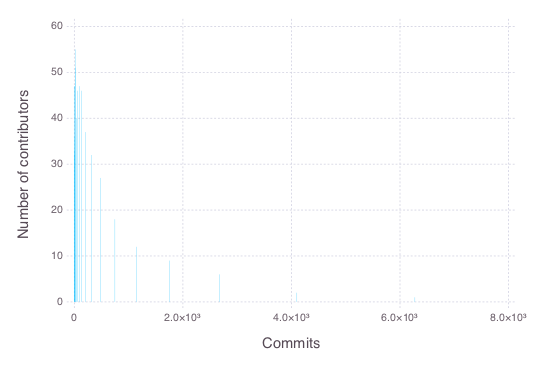

In [18]:
plot(Geom.bar, Guide.xlabel("Commits"), Guide.ylabel("Number of contributors"),
    y=counts, x=midpoints(grid))

# Plotting activity on a world map

Another thing we can do with the data is to place everyone on a world map. One way to plot a world map in Julia is to use `Shapefile.jl` to read in a shape file of the world, and render the result in `Compose.jl`.

There are two wrinkles to deal with:

1. `Compose.rectangle` uses different data to describe rectangles than `Shapefile.Rect`. The former uses `(left, top, width, height)` whereas the latter uses `(left, right, top, bottom)`. We can handle the change in data by defining a new `Compose.rectangle` constructor which takes a `Shapefile.Rect` as input.

2. A `Shapefile.Polygon` can be disjoint while a `Compose.polygon` cannot. The distinction is important when reading in shapefiles with disjoint polygons, e.g. to describe noncontiguous country borders. Here, we define a new `convert` method from the former to a `Vector` of `Compose.polygon`s. We also define our own `Polygons` function to generate a `Vector` of `polygon`s from either a `Polygon` or a `Vector` of `Polygon`s. In the latter case we convert each `Polygon` to a `Vector` of `polygon`s, then flatten the resulting `Vector` of `Vector`s after iterating through all the `Polygon`s.

In [19]:
#Convert Shapefile rectangle to Compose rectangle
Compose.rectangle{T<:Real}(R::Shapefile.Rect{T}) = rectangle(R.left,R.top,R.right-R.left,R.bottom-R.top)

#Compose polygons cannot be disjoint but Shapefile.Polygons can
#Need to convert Shapefile.Polygon to list of Compose polygons
function Base.convert(::Type{Vector{Compose.Form{Compose.PolygonPrimitive}}},
        shape::Shapefile.Polygon)
    points = Any[]
    polygons=Any[]
    currentpart=2
    for (i,p) in enumerate(shape.points)
        push!(points, p)
        if i==length(shape.points) || (currentpart≤length(shape.parts) && i==shape.parts[currentpart])
            push!(polygons, polygon([(p.x,p.y) for p in points]))
            currentpart += 1
            points = Any[]
        end
    end
    polygons
end

Polygons(shape::Shapefile.Polygon) = convert(Vector{Compose.Form{Compose.PolygonPrimitive}}, shape)

#Technically correct only for S=Shapefile.ESRIShape
Polygons{S<:Shapefile.ESRIShape}(shapes::Vector{S}) = [[convert(Vector{Compose.Form{Compose.PolygonPrimitive}},
    shape) for shape in shapes]...]

Polygons (generic function with 2 methods)

Now we are ready to download a map of the world, read it in with `Shapefile.jl`, and draw it in `Compose.jl`.

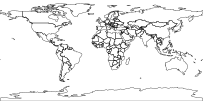

In [20]:
#Load some data about the world's countries
worldshapefile="ne_110m_admin_0_countries.shp"
dl("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/110m_cultural/ne_110m_admin_0_countries.shp", worldshapefile)
worldshape = open(worldshapefile) do f
      read(f, Handle)
end
world=compose(context(), fill(nothing), stroke("black"), Polygons(worldshape.shapes)...)
draw(SVG(8inch, 4inch), compose(context(units=UnitBox(-180, 90, 360, -180)), world))

Next, let's place everyone on the map.

For a given user, we retrieve their reported location on GitHub using `GitHub.user` and look it up on a geocoding service. Here we use [OpenStreetMap's Nominatim](http://wiki.openstreetmap.org/wiki/Nominatim) service to look up a list of candidate locations, and return the first location as a tuple of latitude, longitude and location name. If there are no candidate locations, return `nothing`.

Since we don't have a nice wrapper around Nominatim like we do for GitHub, we have to do all the error handling ourselves. (Note: There is currently a bug in Julia's web stack which makes this code not work for querying locations with non-ASCII characters in them.)

In [87]:
getlatlon(user::AbstractString, my_auth=my_auth) = getlatlon(owner(user, auth=my_auth))

function getlatlon(user::GitHub.Owner, my_auth=my_auth)
    username = get(user.login)
    location = if !isnull(user.location)
        get(user.location) #Read from GitHub.Owner
    else
        try #Work around https://github.com/JuliaWeb/GitHub.jl/issues/51
            #Get user location from GitHub
            user2 = owner(username, auth=my_auth)
            if !isnull(user2.location)
                get(user2.location)
            else
                "" #No location data
            end
        catch
            ""
        end
    end
    strip(location) == "" && return nothing  #Location was missing

    #If user-reported location is already coordinates, then return them
    try
        #test if location is a string of all digits, punctuation or whitespace
        if all(map(x->isdigit(x)|ispunct(x)|isspace(x), collect(location))
            coords = eval(parse(location))
            if typeof(coords) == Tuple{Float64,Float64}
                return (coords[1], coords[2], location)
            end
        end
    end

    #Some simple hacks to normalize locations for Nominatim
    location = replace(location, "U.S.A.", "USA")
    
    #Take location and look up on geocoding service
    try
        responseosm = get(URI("http://nominatim.openstreetmap.org/search"),
        query=@compat Dict("format"=>"json", "q"=>location))
        
        responseosmstr = bytestring(responseosm.data)
        
        if responseosm.status!=200 && contains(responseosm.headers["Content-Type"], "text/html")
            display("text/html", responseosmstr)
        end
        meosm = JSON.parse(responseosmstr)
        if length(meosm)<1
            warn("OpenStreetMaps did not know the location of user $username with reported location \"$location\"")
            return (Inf, Inf, location) #Geocoder doesn't know where this is
        end
        #Return the first hit
        return (float(meosm[1]["lat"]), float(meosm[1]["lon"]), location)
    catch e
        warn("Ignoring bad response from URL: http://nominatim.openstreetmap.org/search?format=json&q=$location")
        println("Error caught: ", e)
        if isdefined(:responseosm)
            if contains(responseosm.headers["Content-Type"], "text/html")
                display("text/html", responseosmstr)
            else
                println(responseosmstr)
            end
        end
        return nothing
    end
end

getlatlon("jiahao", my_auth)

(42.3750997,-71.1056156,"Cambridge, MA")

Now define a function to iterate over a list of authors and add their locations to a `locations` dictionary.

In [105]:
function adduserlocations!(locations::Dict, contributors::Vector{GitHub.Owner})
    @showprogress for user in contributors
        adduserlocation!(locations, user)
    end
end

function adduserlocations!(locations::Dict, contributors::Vector{Any})
    @showprogress for user in contributors
        adduserlocation!(locations, user["contributor"])
    end
end

function adduserlocation!(locations::Dict, user::GitHub.Owner)
    username = get(user.login)
    haskey(locations, username) && return #Don't look up existing data again
    location = getlatlon(user, my_auth)
    location==nothing && return
    locations[username] = location
end

adduserlocation! (generic function with 1 method)

In [ ]:
isdefined(:locations) || (locations=Dict())
adduserlocations!(locations, authors)

Finally we have all the data necessary to render user locations as dots on the world map. We use here a dot size that grows slowly with the number of contributions.

In [165]:
#Render developers
function placeauthors(authors, locations)
    xs = Float64[]; ys=Float64[]; rs=Any[]
    @showprogress for user in authors
        username, n = if isa(user, Dict)
            get(user["contributor"].login), user["contributions"]
        elseif isa(user, GitHub.Owner)
            get(user.login), 1
        end

        haskey(locations, username) || continue
        push!(xs, locations[username][2])
        push!(ys, locations[username][1])
        push!(rs, (1+√log(n))*0.3mm)
    end
    circle(xs, ys, rs)
end

function drawmap(left::Real=-180, right::Real=180, up::Real=90, down::Real=-90,
    composeobjs...; target = SVG(4inch*(right-left)/(up-down),4inch))
    draw(target,
    compose(context(units=UnitBox(left,up,right-left,down-up)), world, composeobjs...))

    #Print users in the box
    #for (user, loc) in locations
    #    if down<loc[1]<up && left<loc[2]<right
    #        println(user, ":", loc)
    #    end
    #end
end

drawmap (generic function with 5 methods)

Finally, we are ready to plot all the Julia contributors on a world map!

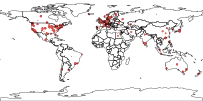

In [92]:
devs=compose(context(), fill("#d66661"), stroke("#c93d39"), linewidth(0.3mm),
        placeauthors(authors, locations))

drawmap(-180, 180, 90, -90, devs)

Using `Interact.@manipulate`, we can make a simple zoomable map with very little effort:

In [ ]:
@manipulate for limit_east=-180:180, limit_west=limit_east.value:180, limit_north=-90:90, limit_south=-90:limit_north.value
    left = limit_east
    right = limit_west
    up = limit_north
    down = limit_south
    box = UnitBox(left, up, right-left, down-up)
    compose(context(units=box), world, devs)
end

In [109]:
adduserlocations!(locations, juliastargazers)

Progress:   0%  ETA: 1:18:00


Use "Paris(" instead.


Progress:   1%  ETA: 1:10:42

Progress:   1%  ETA: 1:07:21


Use "MA(" instead.


Progress:   1%  ETA: 1:07:50

Progress:   1%  ETA: 1:07:18

Progress:   3%  ETA: 1:05:02

Progress:   5%  ETA: 1:01:41

Progress:   6%  ETA: 1:00:44

Progress:   6%  ETA: 0:59:55

Progress:   6%  ETA: 0:59:33

Progress:   7%  ETA: 0:59:00


Use "Any[a,b, ...]" instead.


Progress:   7%  ETA: 0:58:48

Progress:   7%  ETA: 0:58:44

Progress:   7%  ETA: 0:58:49

Progress:   7%  ETA: 0:58:19

Progress:   9%  ETA: 0:56:56


Use "Basel(" instead.


Progress:   9%  ETA: 0:56:43

Progress:  10%  ETA: 0:56:30

Progress:  11%  ETA: 0:55:54

Progress:  12%  ETA: 0:55:25

Progress:  13%  ETA: 0:54:29


Use "CT(" instead.


Progress:  13%  ETA: 0:54:23


Use "Русь(" instead.


Progress:  13%  ETA: 0:53:56

Progress:  13%  ETA: 0:53:28

Progress:  13%  ETA: 0:53:26

Progress:  14%  ETA: 0:52:33

Progress:  17%  ETA: 0:50:29

Progress:  18%  ETA: 0:49:56

Progress:  19%  ETA: 0:48:48

Progress:  20%  ETA: 0:48:08


Use "China(" instead.


Progress:  20%  ETA: 0:47:42

Progress:  21%  ETA: 0:47:25

Progress:  21%  ETA: 0:47:25

Progress:  22%  ETA: 0:46:37


Use "Korea(" instead.


Progress:  23%  ETA: 0:45:53

Progress:  24%  ETA: 0:45:03

Progress:  24%  ETA: 0:44:49

Progress:  25%  ETA: 0:43:52

Progress:  25%  ETA: 0:43:53

Progress:  25%  ETA: 0:43:51

Progress:  26%  ETA: 0:43:34

Progress:  26%  ETA: 0:43:33

Progress:  26%  ETA: 0:43:34

Progress:  26%  ETA: 0:43:34

Progress:  26%  ETA: 0:43:25

Progress:  28%  ETA: 0:42:17

Progress:  29%  ETA: 0:41:47


Use "Madrid(" instead.


Progress:  29%  ETA: 0:41:37

Progress:  29%  ETA: 0:41:34

Progress:  31%  ETA: 0:40:37

Progress:  31%  ETA: 0:40:34

Progress:  35%  ETA: 0:38:27


Use "Grans(" instead.


Progress:  35%  ETA: 0:38:24

Progress:  36%  ETA: 0:37:47

Progress:  37%  ETA: 0:37:19


Use "Ouagadougou(" instead.


Progress:  37%  ETA: 0:37:08

Progress:  37%  ETA: 0:36:56

Progress:  38%  ETA: 0:36:17

Progress:  40%  ETA: 0:35:21

Progress:  40%  ETA: 0:35:16

Progress:  42%  ETA: 0:33:47

Progress:  44%  ETA: 0:33:14


Use "GA(" instead.


Progress:  44%  ETA: 0:33:05

Progress:  44%  ETA: 0:33:03

Progress:  44%  ETA: 0:33:02


Use "Eindhoven(" instead.


Progress:  44%  ETA: 0:33:00

Progress:  46%  ETA: 0:31:54

Progress:  46%  ETA: 0:31:30

Progress:  47%  ETA: 0:31:23

Progress:  47%  ETA: 0:31:17

Progress:  47%  ETA: 0:30:47

Progress:  49%  ETA: 0:29:34

Progress:  50%  ETA: 0:29:08

Progress:  51%  ETA: 0:28:16

Progress:  52%  ETA: 0:27:43

Progress:  53%  ETA: 0:27:29


Use "XiaMen(" instead.


Progress:  53%  ETA: 0:27:26

Progress:  54%  ETA: 0:27:06

Progress:  54%  ETA: 0:26:51

Progress:  55%  ETA: 0:26:23

Progress:  57%  ETA: 0:24:55

Progress:  60%  ETA: 0:23:28

Progress:  60%  ETA: 0:23:07

Progress:  61%  ETA: 0:22:58

Progress:  63%  ETA: 0:21:48

Progress:  64%  ETA: 0:21:08

Progress:  64%  ETA: 0:20:46

Progress:  65%  ETA: 0:20:16

Progress:  66%  ETA: 0:19:40

Progress:  67%  ETA: 0:19:27

Progress:  67%  ETA: 0:19:17


Use "Grenoble(" instead.


Progress:  68%  ETA: 0:18:33

Progress:  69%  ETA: 0:18:04

Progress:  70%  ETA: 0:17:37

Progress:  70%  ETA: 0:17:24

Progress:  70%  ETA: 0:17:23

Progress:  71%  ETA: 0:17:06

Progress:  71%  ETA: 0:17:06


Use "Lausanne(" instead.

Use "Annecy(" instead.


Progress:  71%  ETA: 0:16:48

Progress:  71%  ETA: 0:16:44

Progress:  71%  ETA: 0:16:43


Use "London(" instead.


Progress:  74%  ETA: 0:15:20

Progress:  74%  ETA: 0:15:16

Progress:  74%  ETA: 0:15:14

Progress:  77%  ETA: 0:13:33

Progress:  77%  ETA: 0:13:26

Progress:  77%  ETA: 0:13:05

Progress:  78%  ETA: 0:12:59

Progress:  79%  ETA: 0:12:16

Progress:  81%  ETA: 0:11:11

Progress:  82%  ETA: 0:10:38

Progress:  82%  ETA: 0:10:21

Progress:  82%  ETA: 0:10:09

Progress:  83%  ETA: 0:10:06

Progress:  83%  ETA: 0:10:01

Progress:  84%  ETA: 0:09:25

Progress:  85%  ETA: 0:08:40

Progress:  86%  ETA: 0:07:49

Progress:  87%  ETA: 0:07:38

Progress:  87%  ETA: 0:07:36

Progress:  87%  ETA: 0:07:27

Progress:  88%  ETA: 0:07:05

Progress:  89%  ETA: 0:06:15

Progress:  89%  ETA: 0:06:12

Progress:  90%  ETA: 0:05:57

Progress:  90%  ETA: 0:05:40

Progress:  90%  ETA: 0:05:34

Progress:  91%  ETA: 0:05:15

Progress:  92%  ETA: 0:04:43

Progress:  93%  ETA: 0:04:16

Progress:  93%  ETA: 0:04:03


Use "Warsaw(" instead.


Progress:  94%  ETA: 0:03:22

Progress:  94%  ETA: 0:03:14

Progress:  95%  ETA: 0:02:54

Progress:  97%  ETA: 0:01:40

Progress:  99%  ETA: 0:00:44

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:43

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:43

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:42

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:42

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:41

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:39

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:38

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:37

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:36

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:32

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:31

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:31

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:29

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:27

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:26

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:25

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:22

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:21

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:20

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:20

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:19

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  99%  ETA: 0:00:18

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:17

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:16

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:16

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:15

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:13

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:13

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:12

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:12

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:09

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:08

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:08

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:07

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:07

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:06

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:04

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:03

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:03

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:02

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:02

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:01

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100%  ETA: 0:00:01

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException

## Stargazers and watchers

We can also retrieve similar data for stargazers and watchers.

In [ ]:
# Get stargazers
juliastargazers = stargazers("JuliaLang/julia", auth=my_auth)[1]
adduserlocations!(locations, juliastargazers)

In [110]:
# Get watchers
juliawatchers = watchers("JuliaLang/julia", auth=my_auth)[1]
adduserlocations!(locations, juliawatchers)

("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress: 100% Time: 0:58:35
Progress:   2%  ETA: 0:00:58

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:   2%  ETA: 0:01:16

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:   3%  ETA: 0:01:34

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:   3%  ETA: 0:01:48

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:   4%  ETA: 0:01:51

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:   4%  ETA: 0:02:00

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:   6%  ETA: 0:01:43

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:   6%  ETA: 0:01:54

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:   7%  ETA: 0:02:02

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  12%  ETA: 0:01:39

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  12%  ETA: 0:01:42

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  13%  ETA: 0:01:43

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  13%  ETA: 0:01:44

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  13%  ETA: 0:01:45

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  14%  ETA: 0:01:42

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  15%  ETA: 0:01:44

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  16%  ETA: 0:01:42

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  18%  ETA: 0:01:39

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  19%  ETA: 0:01:35

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  20%  ETA: 0:01:33

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  22%  ETA: 0:01:30

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  22%  ETA: 0:01:31

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  23%  ETA: 0:01:32

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  24%  ETA: 0:01:31

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  24%  ETA: 0:01:30

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  26%  ETA: 0:01:28

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  28%  ETA: 0:01:27

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  29%  ETA: 0:01:27

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  29%  ETA: 0:01:27

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  30%  ETA: 0:01:28

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  31%  ETA: 0:01:26

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  32%  ETA: 0:01:24

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  33%  ETA: 0:01:23

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  34%  ETA: 0:01:23

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  34%  ETA: 0:01:23

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  36%  ETA: 0:01:22

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  39%  ETA: 0:01:19

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  41%  ETA: 0:01:16

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  41%  ETA: 0:01:15

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  44%  ETA: 0:01:10

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  45%  ETA: 0:01:10

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  47%  ETA: 0:01:06

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  49%  ETA: 0:01:03

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  52%  ETA: 0:00:58

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  53%  ETA: 0:00:57

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  54%  ETA: 0:00:57

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  55%  ETA: 0:00:55

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  57%  ETA: 0:00:52

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  59%  ETA: 0:00:50

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  59%  ETA: 0:00:50

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  61%  ETA: 0:00:47

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  62%  ETA: 0:00:47

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  62%  ETA: 0:00:46

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  63%  ETA: 0:00:46

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  63%  ETA: 0:00:46

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  64%  ETA: 0:00:45

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  65%  ETA: 0:00:44

Bandwidth limit exceeded 
 
 
 Bandwidth limit exceeded 

 You have been temporarily blocked because you have been overusing OSM's geocoding service or because you have not provided sufficient identification of your application. This block will be automatically lifted after a while. Please take the time and adapt your scripts to reduce the number of requests and make sure that you send a valid UserAgent or Referer. 

 For more information, consult the usage policy for the OSM Nominatim server.

Error caught: ErrorException("Unknown value\nLine: 0\nAround: ...<html> <head> <title>...\n           ^\n")
Progress:  69%  ETA: 0:00:38

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  71%  ETA: 0:00:35

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  71%  ETA: 0:00:35

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  72%  ETA: 0:00:34

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  73%  ETA: 0:00:33

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  75%  ETA: 0:00:30

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  76%  ETA: 0:00:29

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  76%  ETA: 0:00:29

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  78%  ETA: 0:00:26

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  79%  ETA: 0:00:26

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  81%  ETA: 0:00:23

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  85%  ETA: 0:00:18

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  87%  ETA: 0:00:16

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  88%  ETA: 0:00:15

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  89%  ETA: 0:00:13

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  90%  ETA: 0:00:13

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  90%  ETA: 0:00:12

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  92%  ETA: 0:00:10

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  93%  ETA: 0:00:09

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  93%  ETA: 0:00:09

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  95%  ETA: 0:00:06

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  96%  ETA: 0:00:04

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  98%  ETA: 0:00:03

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  98%  ETA: 0:00:02

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  99%  ETA: 0:00:01

Error caught: connect: connection refused (ECONNREFUSED)
Progress:  99%  ETA: 0:00:01

Error caught: connect: connection refused (ECONNREFUSED)
Progress: 100%  ETA: 0:00:00

Error caught: connect: connection refused (ECONNREFUSED)

In [118]:
#Render stargazers and watches
stars=compose(context(), fill(nothing), stroke("#945bb0"),
    placeauthors(juliastargazers, locations))

watches=compose(context(), fill("#6bab5b"),
    placeauthors(juliawatchers, locations));

drawmap(-180, 180, 90, -90, devs, stars, watches)

In [167]:
drawmap(-180, 180, 90, -90, devs, stars, watches, target=PNG("worldofjulia.png", 8inch, 4inch))

In [114]:
@manipulate for limit_east=-180:180, limit_west=limit_east.value:180, limit_north=-90:90, limit_south=-90:limit_north.value
    left = limit_east
    right = limit_west
    up = limit_north
    down = limit_south
    box = UnitBox(left, up, right-left, down-up)
    compose(context(units=box), world, devs, stars, watches)
end

Interact.Slider{Int64}(Signal{Int64}(0, nactions=0),"limit_east",0,-180:180,true)

Interact.Slider{Int64}(Signal{Int64}(90, nactions=0),"limit_west",90,0:180,true)

Interact.Slider{Int64}(Signal{Int64}(0, nactions=0),"limit_north",0,-90:90,true)

Interact.Slider{Int64}(Signal{Int64}(-45, nactions=0),"limit_south",-45,-90:0,true)

LoadError: LoadError: UndefVarError: stars not defined
while loading In[114], in expression starting on line 1

# Save data

Finally, we can save all the data we have painstakingly collected using `HDF5.JLD.save`, so that we may use it in further analysis.

In [151]:
JLD.save("worldofjulia.jld",
    #Currently can't be saved - https://github.com/JuliaLang/JLD.jl/issues/61
    #"allcontributors", authors,
    #"juliacontributors", juliacontributors,
    #"juliastargazers", juliastargazers, 
    #"juliawatchers", juliawatchers,
    "locations", locations
)